# 端对端场景文本识别

论文：
[An End-to-End Trainable Neural Network for Image-based Sequence Recognition and Its Application to Scene Text Recognition](http://arxiv.org/abs/1507.05717)

In [1]:
import os
import math
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image


/home/han/.local/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/han/.local/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
#本人电脑显存2G
#数据集使用trdg生成，训练5单词时batch_size=16,占用显存最高1.8G，训练1单词时可使用batch_size=32，显存占用不超过1G
batch_size = 16
lr=0.0005  #使用Adadelta优化器，不需要学习率，使用Adam时需要
num_epochs = 30
input_channels = 3

trainDataPath = "/home/han/Documents/SRP/dataset/withBackground/traindata/"
#trainDataPath = "/home/han/Documents/SRP/dataset/traindata/"
#trainDataPath = "/home/han/Documents/SRP/crnn.pytorch/tool/traindata/"

testDataPath = "/home/han/Documents/SRP/dataset/withBackground/testdata/"
#testDataPath = "/home/han/Documents/SRP/dataset/testdata/"
#testDataPath = "/home/han/Documents/SRP/crnn.pytorch/tool/testdata/

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

char_to_int = {char: i for i, char in enumerate('*0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ- ')}
int_to_char = {i: c for c, i in char_to_int.items()}
num_classes = len(char_to_int)
print(num_classes)

65


## 1. 定义网络

In [3]:
class CRNN(nn.Module):
    def __init__(self, num_classes, input_channels=1):
        super(CRNN, self).__init__()

        # Convolutional Layers
        self.conv = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1), #1
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), #2
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), #3
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), #4
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1)),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), #5
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), #6
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1)),

            nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=0), #7
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        # Recurrent Laysers
        self.lstm1 = nn.LSTM(input_size=512, hidden_size=256, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=512, hidden_size=256, bidirectional=True)
        
        # Fully connected layer
        self.fc = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = self.conv(x)
        b, c, h, w = x.size()  #batch, channel, height, width
        x = x.squeeze(2)
        x = x.permute(2, 0, 1)

        
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)


        x = self.fc(x)

        return x

crnn = CRNN(num_classes=num_classes,input_channels=input_channels).to(device)

## 2. 数据加载

In [4]:
"""
def encode_label(label):
    encoded = [char_to_int[ch] for ch in label]
    return torch.tensor(encoded)

def decode_label(label):
    decoded = ''.join([int_to_char[val.item()] for val in label])
    return decoded

def decode_labels(labels):
    decoded = []
    for label in labels:
        decoded.append(decode_label(label))
    return decoded
"""

"\ndef encode_label(label):\n    encoded = [char_to_int[ch] for ch in label]\n    return torch.tensor(encoded)\n\ndef decode_label(label):\n    decoded = ''.join([int_to_char[val.item()] for val in label])\n    return decoded\n\ndef decode_labels(labels):\n    decoded = []\n    for label in labels:\n        decoded.append(decode_label(label))\n    return decoded\n"

In [5]:
def encode_label(label):
    encoded = [char_to_int[ch] for ch in label]
    return torch.tensor(encoded)


def encode_labels(labels):
    encoded = []
    lengths = []
    for label in labels:
        encoded_label = [char_to_int[ch] for ch in label]
        encoded.extend(encoded_label)
        lengths.append(len(encoded_label))
    return torch.tensor(encoded), lengths

print(len(char_to_int))

def decode_labels(labels):
    output_labels = []
    for label in labels:
        decoded_text = ""
        for val in label:
            value = val.item()
            if value == 0:
                continue
            if value in int_to_char:
                decoded_text += int_to_char[value]
        output_labels.append(decoded_text)
    return output_labels

def decode_output_labels(preds):
    output_labels = []
    for pred in preds:
        decoded_text = ""
        prevalue = 0
        for p in pred:
            value = p.item()
            if value == 0:
                prevalue = value
                continue
            if value == prevalue:
                continue
            if value in int_to_char:
                decoded_text += int_to_char[value]
            prevalue = value
        output_labels.append(decoded_text)
    return output_labels

65


In [6]:
import os
from PIL import Image
import torch
from torchvision import transforms

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Get file path
        img_name = os.path.join(self.root_dir, self.file_list[idx])
        # Open image
        image = Image.open(img_name)#.convert('L')

        #文件命名格式为”{label}_{num}.jpg“，num仅仅是一个文件的序号，没有实际意义
        label = self.file_list[idx].split('_')[0]
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        
        return image, encode_label(label)


class ResizeKeepAspectRatio:
    def __init__(self, height):
        self.height = height

    def __call__(self, img):
        # 计算新的宽度，以保持原始的宽高比
        aspect_ratio = float(img.width) / float(img.height)
        new_width = int(aspect_ratio * self.height)
        return img.resize((new_width, self.height), Image.BILINEAR)

if input_channels == 1:
    transform = transforms.Compose([
        ResizeKeepAspectRatio(32), #将图片的高度调整为32，并保持宽高比
        transforms.Grayscale(), 
        transforms.ToTensor(),
        transforms.Normalize(0.5, 0.5) 
    ])
    print("1 channel")
else:
    transform = transforms.Compose([
        ResizeKeepAspectRatio(32), #将图片的高度调整为32，并保持宽高比
        #transforms.Grayscale(), 
        transforms.Lambda(lambda x: x.convert("RGB")),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) 
    ])
    print("3 channels")

def collate_fn(batch):
    # 获取所有图像的宽度，shape为[c,h,w]，w为宽度
    dims = [img.shape[2] for img, _ in batch]
    # 获取最大的宽度
    max_dim = max(dims)

    # 获取所有标签的长度
    label_lengths = [len(label) for _, label in batch]
    # 获取最大的标签长度
    max_label_length = max(label_lengths)

    # 创建填充后的图像张量和标签张量列表
    padded_imgs = []
    padded_labels = []
    for (img, label) in batch:
        # 计算需要填充的宽度
        padding_img = max_dim - img.shape[2]
        # 使用torch的函数来填充图像 (left=0, right=padding_img, top=0, bottom=0)
        padded_img = torch.nn.functional.pad(img, (0, padding_img, 0, 0))
        padded_imgs.append(padded_img)

        # 对于标签，使用零填充至最大长度
        padding_label = max_label_length - len(label)
        padded_label = torch.cat([label, torch.zeros(padding_label, dtype=torch.long)], dim=0)
        padded_labels.append(padded_label)

    return torch.stack(padded_imgs, 0), torch.stack(padded_labels, 0)

#train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

#加载数据集
train_dataset = CustomDataset(root_dir=trainDataPath, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)


3 channels


In [7]:

def images_show(imgs,labs=[]):
    i=0
    #w = math.ceil(len(imgs)/2)
    for img in imgs:
      
        plt.title(labs[i])
        if(input_channels == 1):
            plt.imshow(img.cpu().squeeze(0),plt.cm.gray)
        else:
            plt.imshow(img.cpu().numpy().transpose(1,2,0)/2 + 0.5)
        plt.show()
        i+=1
        if  i >= 8:
            print(f"Maximium Images for images_show: {i}")
            break

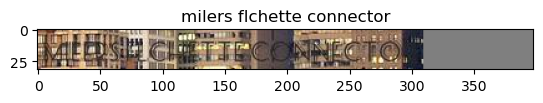

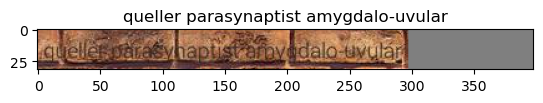

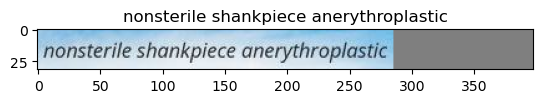

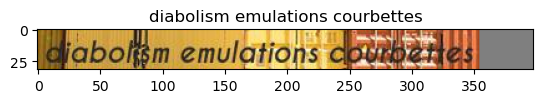

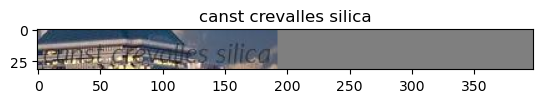

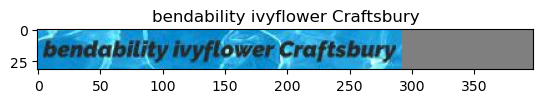

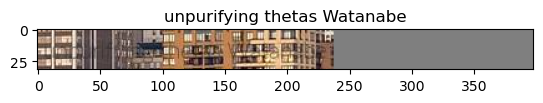

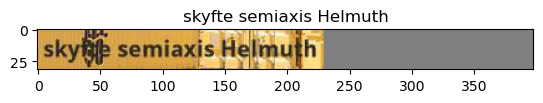

Maximium Images for images_show: 8


In [8]:
for i, (images, labels) in enumerate(train_loader):
    images_show(images,decode_labels(labels))
    break

## 3. 优化器与损失函数

In [9]:
# 优化器
#optimizer = torch.optim.Adam(crnn.parameters(), lr=lr)
optimizer = torch.optim.Adadelta(crnn.parameters())

# 损失函数
criterion = nn.CTCLoss()

## 4. 训练

In [ ]:
#删除空白的填充
def delete_padding_labels(labels):
    labels_d = []
    for label in labels:
        label_d = label.numpy().tolist()
        label_d = [x for x in label_d if x != 0]
        labels_d.append(label_d)
    return labels_d


def encode_label_list(label_list):
    encoded = []
    lengths = []
    for label in label_list:
        encoded.extend(label)
        lengths.append(len(label))
    return torch.tensor(encoded),lengths


#训练模型

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        
        optimizer.zero_grad()

        outputs = crnn(images)
        outputs = outputs.log_softmax(2)
        
        encoded_labels,label_lengths = encode_label_list(delete_padding_labels(labels))
         
        
        output_lengths = torch.full((outputs.size(1),), outputs.size(0), dtype=torch.long)

        loss = criterion(outputs, encoded_labels, output_lengths, torch.tensor(label_lengths))
        #print(f"loss:{loss}")
        loss.backward()

        optimizer.step()

        if (i+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item()}')

Epoch [1/30], Step [10/622], Loss: 3.638319492340088
Epoch [1/30], Step [20/622], Loss: 3.1822752952575684
Epoch [1/30], Step [30/622], Loss: 3.416149139404297
Epoch [1/30], Step [40/622], Loss: 3.206063985824585
Epoch [1/30], Step [50/622], Loss: 3.389341354370117
Epoch [1/30], Step [60/622], Loss: 3.3194732666015625
Epoch [1/30], Step [70/622], Loss: 3.2061400413513184
Epoch [1/30], Step [80/622], Loss: 3.26346492767334
Epoch [1/30], Step [90/622], Loss: 3.2653398513793945
Epoch [1/30], Step [100/622], Loss: 3.3715627193450928
Epoch [1/30], Step [110/622], Loss: 3.4011566638946533
Epoch [1/30], Step [120/622], Loss: 3.1394617557525635
Epoch [1/30], Step [130/622], Loss: 3.329601764678955
Epoch [1/30], Step [140/622], Loss: 3.210613250732422
Epoch [1/30], Step [150/622], Loss: 3.1985130310058594
Epoch [1/30], Step [160/622], Loss: 3.487971067428589
Epoch [1/30], Step [170/622], Loss: 3.299060344696045
Epoch [1/30], Step [180/622], Loss: 3.225898027420044
Epoch [1/30], Step [190/622], 

## 保存训练权重

In [ ]:
#PATH = './crnn_str_multi_v.pth'
PATH = './crnn_str_background.pth'
torch.save(crnn.state_dict(), PATH)

## 测试评估

In [ ]:
#device = "cpu"

#PATH = './crnn_str_multi_v.pth'
PATH = './crnn_str_background.pth'
net = CRNN(num_classes=num_classes,input_channels=input_channels).to(device)

if device == "cpu":
    net.load_state_dict(torch.load(PATH, map_location='cpu'))
else:
    net.load_state_dict(torch.load(PATH))

net.eval()

test_dataset = CustomDataset(root_dir=testDataPath, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=4, collate_fn=collate_fn)

#for i, (images, labels) in enumerate(test_loader):
#    images_show(images,decode_output_labels(labels))
#    break
    

In [ ]:
# 对测试数据进行评估
test_accuracy = 0.0
total_samples = 0

i=0


with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = net(images)

        _, predicted = torch.max(outputs,2)  # 第2个维度是类别维度)
        
        if(i==0):
            images_show(images,decode_output_labels(predicted.t()))
            #print(decode_output_labels(predicted.t()))
            #print(decode_labels(labels))
        
        test_accuracy += sum(1 for a, b in zip(decode_output_labels(predicted.t()),
                                               decode_labels(labels)) if a == b)

        total_samples += len(labels)
        i+=1
        if i==5:
            #break
            continue
        if((i+1)%10 == 0):
            print(f"test procees:{i+1}/{len(test_loader)}")

test_accuracy /= total_samples
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
